In this example we'll perform a causal analysis to estimate the effect of injectables as a form of contraception on discontinuation for health concern reasons. 

**Background**

One of the indicators of the sustainable development goal is the percentage of women of reproductive age who have their need for family planning satisfied with modern methods ([Source](https://www.ippf.org/sites/default/files/2016-11/SDG%20and%20FP2020.pdf)). As a result, the dynamics of contraceptive use continuation, switching and failure
are important markers when designing programmes to meet the family planning needs of women and couples globally.

In this analysis, we focus one such marker: Contraceptive Discontinuation (or simply discontinuation). Discontinuation refers to an event where a specific contraceptive method is discontinued within 12 months after beginning its use by a woman of reproductive age. 

Discontinuation rates are often obtained from surveys such as those carried out by [The Demographic and Health Surveys (DHS) Program](https://dhsprogram.com/). The DHS records 5-year contraceptive use for individual women in specific countries as well as reasons for discontinuation at any time in the same period. This is refered to as calendar data.

According to a [study](https://apps.who.int/iris/bitstream/handle/10665/75429/9789241504058_eng.pdf) done using DHS data from 60 countries, method-related dissatisfaction is the most common reason for discontinuation for all contraceptive methods except periodic abstinence and withdrawal. In addition, Injectable users report the highest likelihood of discontinuation due to method-related dissatisfaction; 35% by the end of the first year, rising to 51% by the end of the second year.  Method-related dissatisfaction comprise of desire to switch to a more effective method, problems of cost or access, husband’s objections, and side-effects/health concerns.



**Causal Analysis**

In this analysis we'll estimate the effect of the use of injectables on discontinuation due to health concerns using data from 1-year contraceptive use, as well as other demographic data in the DHS Survey for [Kenya in 2014](https://dhsprogram.com/what-we-do/survey/survey-display-451.cfm).


**Preprocessing**

We [preprocess](./Preprocess.ipynb) the data in the following steps:

1. The DHS contain different records. We use the individual record (or women survey)
2. The individual record contains different sections. We use data from Respondents basic data, Reproduction, Contraceptive table, Fertility preferences, and Marriage. These sections contain potential confounders. We obtain data for 14,741 women
3. We only select features/columns with at least 90% non-null values, and imput null values with the median of the column. This leaves us with 85 columns
4. We remove individuals with no use of contracpetion in any month of the past year from the survey, individuals that reported discontinuation becuase they wanted to become pregnant and individuals that were pregnant in the past year. This leaves us with 5,649 women.
5. The treatement is the use of injectables in the past year (coded as method '3' in the calendar data)
6. The outcome is discontinuation for health concern reason in the past year (coded as reason '4' in the calendar data)

In [1]:
%matplotlib inline

import matplotlib
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

from causallib.estimation import IPW
from causallib.evaluation import PropensityEvaluator, OutcomeEvaluator


In [17]:
data = pd.read_csv('fp_injectables_data_overrule_overlap.csv', index_col=0)
len(data)

5062

**Encoding**

Some of the features are categorical (although they have numeric values), so we can encode them using `OrdinalEncoder` for the ordinal features and `OneHotEncoder` for nominal features. We provide a csv file where each of the 85 features are labelled as either categorical ('O' for ordinal and 'L' for Nominal) or discrete ('N')

In [9]:
encoding = pd.read_csv('encoding.csv')

In [19]:
# Select and Encode ordinal features
v = encoding[encoding['encoding'] == 'O']['var_name'].values
enc = OrdinalEncoder()
ord_data = enc.fit_transform(data[v].astype(int))
ord_features = v

In [20]:
# Select and Encode nominal features
v = encoding[encoding['encoding'] == 'L']['var_name'].values
enc = OneHotEncoder()
nom_data = enc.fit_transform(data[v].astype(int))
nom_features = enc.get_feature_names(v)

/home/victora/.local/lib/python3.5/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [21]:
# Select the discrete features
v = encoding[encoding['encoding'] == 'N']['var_name'].values
dis_data = data[v].values
dis_features = v

In [22]:
# Combine all the features
X = np.concatenate((ord_data, nom_data.toarray(), dis_data), axis=1)
features_names = np.concatenate((ord_features, nom_features, dis_features))

In [23]:
X_df = pd.DataFrame(X, columns=features_names)

In [24]:
X_df.head()

,v106,v133,v149,v157,v158,v159,v190,v301,v101_1.0,v101_2.0,...,v227,v235,v238,v525,v531,v613,v614,v627,v628,v629
0,2.0,10.0,3.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,...,0.0,2.0,0.0,17.0,17.0,4.0,4.0,2.0,2.0,0.0
1,1.0,7.0,1.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,...,0.0,1.0,0.0,17.0,17.0,3.0,3.0,1.0,2.0,0.0
2,2.0,12.0,4.0,0.0,2.0,2.0,3.0,0.0,0.0,0.0,...,0.0,0.0,1.0,22.0,21.0,4.0,4.0,2.0,2.0,0.0
3,1.0,8.0,2.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,...,0.0,2.0,0.0,15.0,15.0,4.0,4.0,0.0,0.0,4.0
4,1.0,8.0,2.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,...,0.0,2.0,0.0,18.0,18.0,2.0,2.0,1.0,1.0,0.0


In [25]:
y = data['outcome']
a = data['treatment']

**The Causal Model**

We use IPW with a Calibrated Logistic regression learner. See [this notebook](https://github.com/IBM/causallib/blob/master/examples/ipw.ipynb) for more details on IPW

In [26]:
# Train
learner = CalibratedClassifierCV(base_estimator=LogisticRegression(solver='liblinear', max_iter=2000), cv=5, method='isotonic')
ipw = IPW(learner, use_stabilized=True)
ipw.fit(X_df, a)


IPW(truncate_eps=None, use_stabilized=True,
    learner=CalibratedClassifierCV(base_estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
            cv=5, method='isotonic'))

In [27]:
# Estimate the average outcome:
outcomes = ipw.estimate_population_outcome(X_df, a, y)
outcomes

0    0.065030
1    0.107363
dtype: float64

In [28]:
# Estimate the effect:
effect = ipw.estimate_effect(outcomes[1], outcomes[0], )
effect

diff    0.042333
dtype: float64

**Result**

Our results show that if all the women surveyed used injectables, the probability of discontinuation due to health concerns would be **6.3%** more than if they all did not use injectables.

**Evaluation**

Let's go ahead and evaluate our modelling approach. We can look at the how well the Logistic regression model captures the propensity of each individual with the `PropensityEvaluator`

In [29]:
evaluator = PropensityEvaluator(ipw)
simpleresults = evaluator.evaluate_simple(X_df, a, y, plots=None)

In [30]:
simpleresults.scores.prediction_scores

,0/1,accuracy,avg_precision,brier,f1,hinge,matthews,precision,recall,roc_auc
0,0.227578,0.772422,0.551126,0.156776,0.28801,1.068722,0.279236,0.723602,0.179784,0.771664


We can also assess for positivity violations in the data by looking at unbalanced covariates and overlap in the propensity distribution. In addition, we can check for model misspecification with the calibration plot

/home/victora/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:543: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/home/victora/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/victora/.local/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


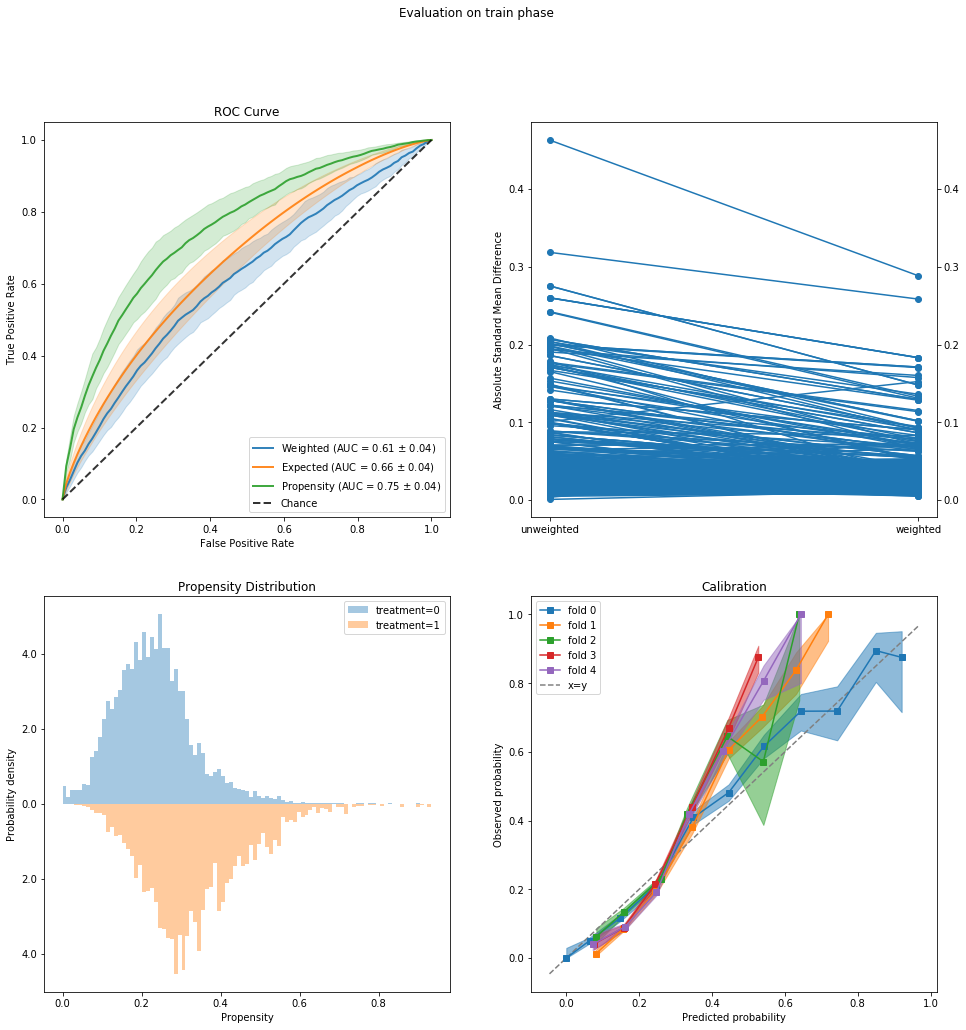

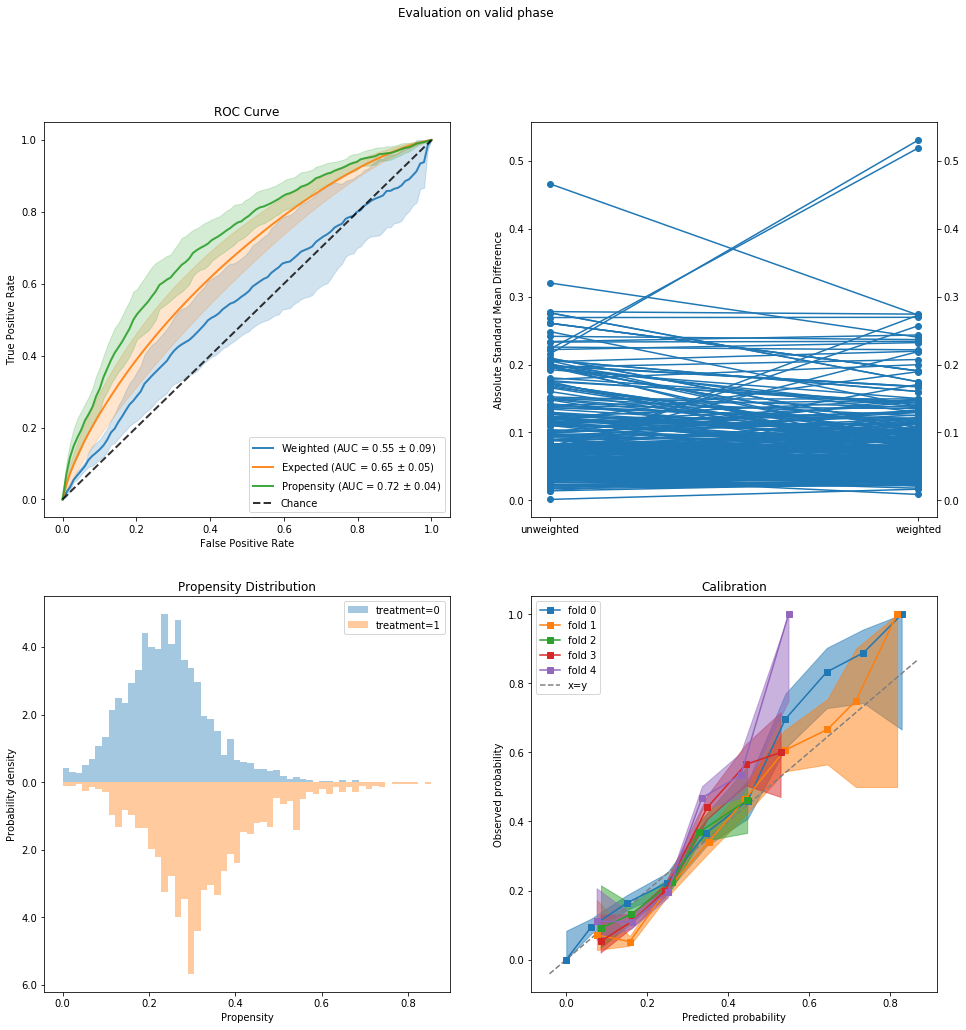

In [31]:
plots=["roc_curve", "covariate_balance_slope", "weight_distribution", "calibration"]
evaluator = PropensityEvaluator(ipw)
cvresults = evaluator.evaluate_cv(X_df, a, y, plots=plots)


Looks like our model is mostly okay. There are a few imbalanced covariates even after weighting. We can take a look at those

In [32]:
cov_bal = cvresults.scores.covariate_balance
imbalanced_cov = cov_bal.loc[('valid')].groupby('covariate').mean()\
                        .sort_values(by='weighted', ascending=False).head(n=10)

In [33]:
imbalanced_cov_list = imbalanced_cov.index.tolist()

cov_list = [cov.split('_')[0] for cov in imbalanced_cov_list]
cov_list_category = [cov.split('_')[1] if len(cov.split('_')) > 1 else '' for cov in imbalanced_cov_list]

In [34]:
_encoding = encoding.set_index('var_name')

cov_df = _encoding.loc[cov_list]
cov_df['category'] = pd.Series(cov_list_category, index=cov_df.index)
cov_df[['label', 'category']]

,label,category
var_name,,
v139,De jure region of residence,1.0
v101,Region,1.0
v101,Region,8.0
v101,Region,4.0
v312,Current contraceptive method,3.0
v139,De jure region of residence,8.0
v139,De jure region of residence,4.0
v139,De jure region of residence,5.0
v513,Cohabitation duration (grouped),1.0


It appears certain regions and ethnicity may have a disproportionate distribution between the treated and untreated groups and possibly mean that there's positivity violation in the data. Considering that we're using observational data and thus individuals self-assign to the treatment this is not too surprising. We may simply remove the covariates or use other techniques to further characterize the positivty violation (See [here](https://arxiv.org/abs/1907.08127)), but that's outside the scope of this example.